# Final Project | Running a local cafe

## By Vyanna Hill

For the PowerPoint Presentation, It can be viewed [here](https://docs.google.com/presentation/d/1zn4eHRv98BcckN4bCf_yymn9hTI41kg0rI4do_1VQjs/edit?usp=sharing)!

### Our foundation

For the final project,This model will represent the traffic that a local college cafe might receive throughout its hours of operation. The premise of this model is for the owner to reduce the service time at their shop and increased the number of customers in the day. The flowchart below shows the path of the paid customer. We removed the possibility that a customer comes into the store and leaves immediately. The owner expects that a cashier will take five minutes to make for their order and check out at the counter. However, it is not garunetee that they are the first line in line at the register.The owner wants to improve the checkout process as the orders enter in a queue. In part of the checkout process, the cafe offers a small seating section where students use to study after their checkout. The owner wants to make sure students are not waiting long times for open space.

### Flow model of the bakery

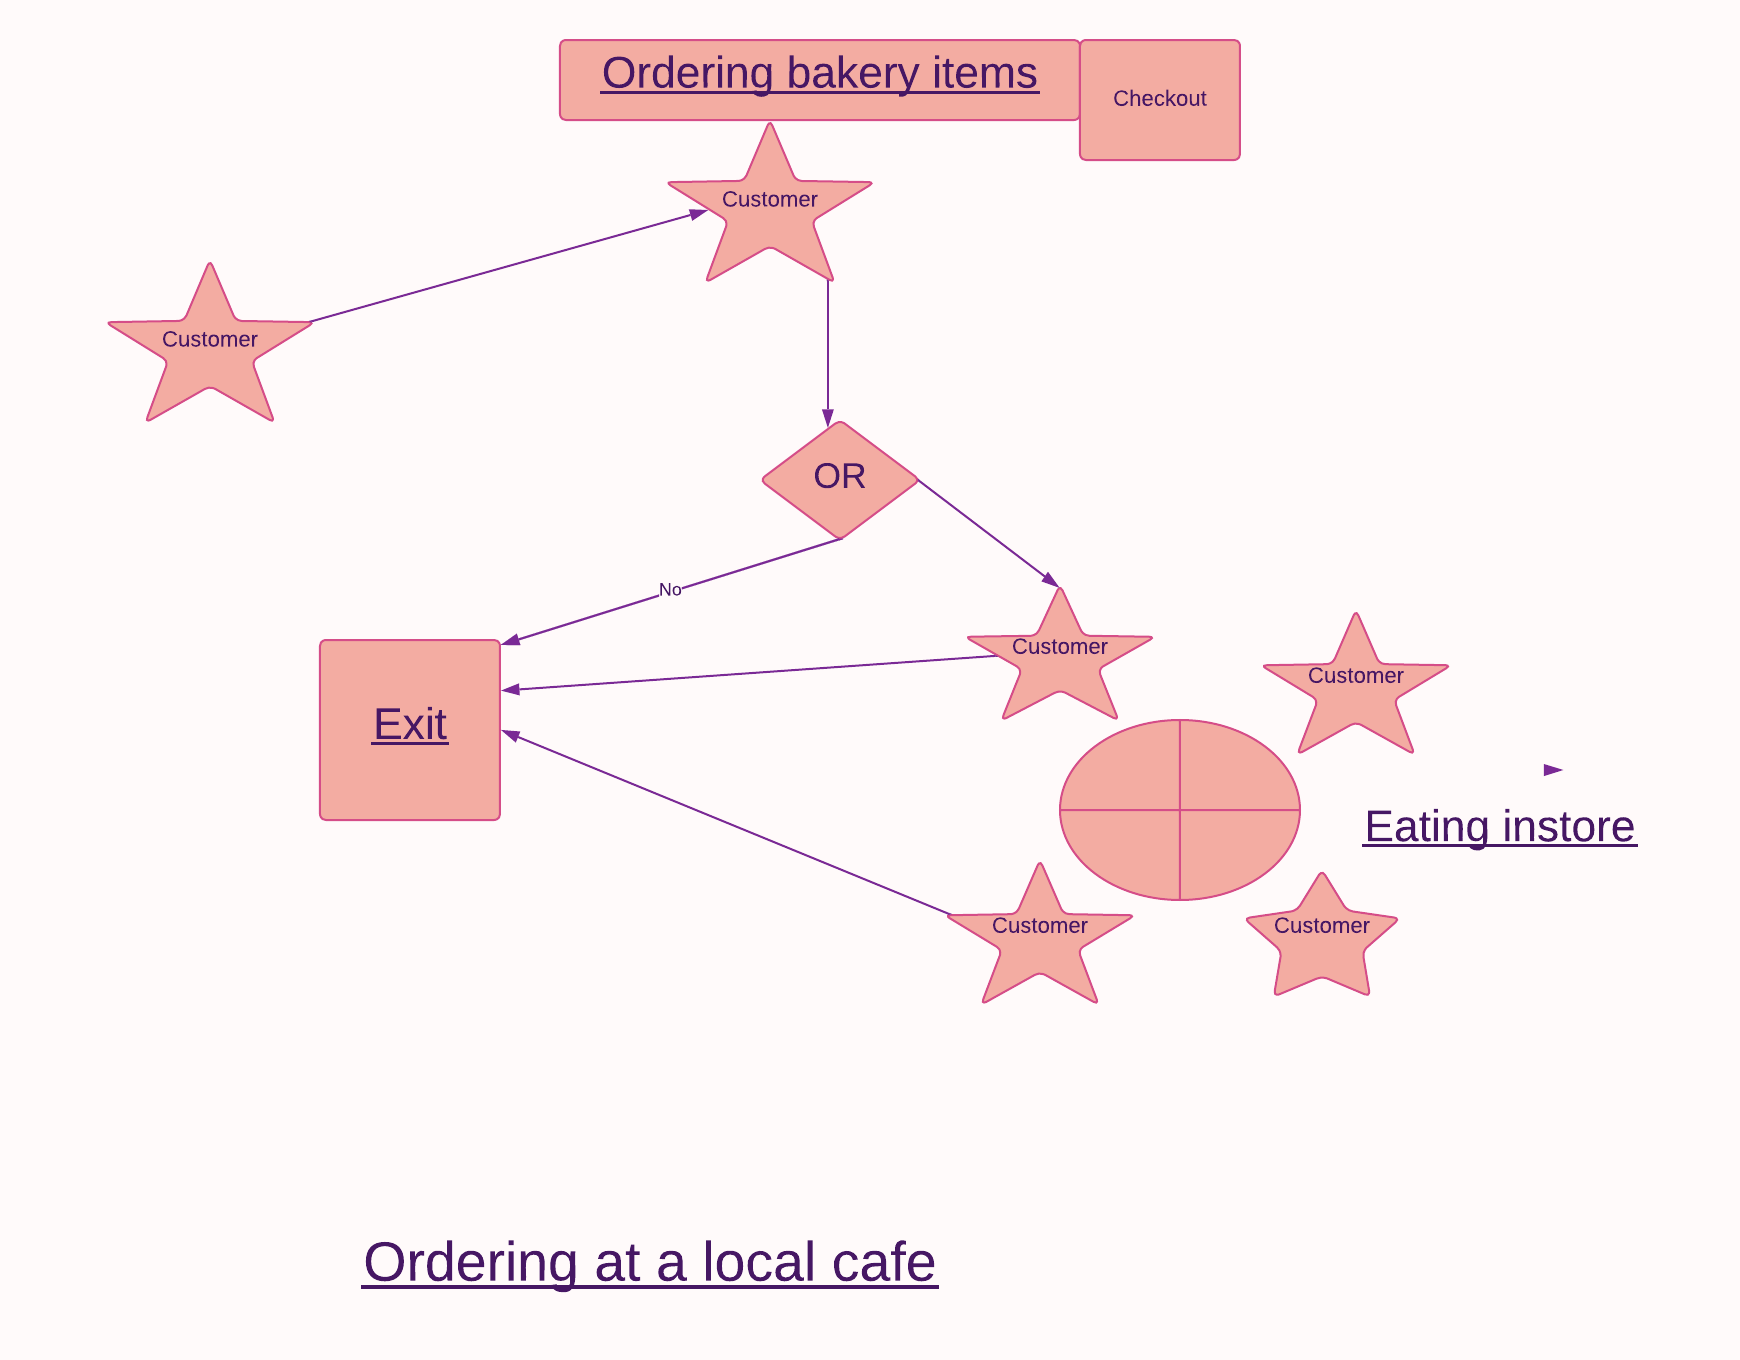

### Our current system

The first part of our system is for our customers who are ready to order. These customers are ready to order once a cashier is free. Then, it will take on average around five minutes for checkout. Now, the customers either leave the store or stay in the small seating area to enjoy their snacks or study before class. The variation of this time is between five minutes to an hour depending on the student's decesion. Students who choose to stay are willing to wait the time after their checkout for the seating area, which currently has four seating arrangements. However, all students will leave the cafe regardless of their decision. 

### System Veritification

To verify our current model, we ran the enviroment for a entire month throughout the hours of operations. The cafe is open from 7am to 6pm to accomendate the large amount of students in the area for morning classes.

In [1]:
import simpy, random,matplotlib.pyplot as pl, numpy as np, pandas as pd
from modsim import *
from statistics import mean
%matplotlib inline

seat_queue=[]
counter_queue=[]
time_inStore=[]
next_seat=[]
avg_ck=[]
avg_inStore=[]
avg_seating=[]
CHECK_OUT_TIME=5
CASHIERS=1
SEATING=4
SEAT_PROB=.25
CUSTOMER_ARR=5

In [2]:
class Bakery(object):
    def __init__(self,env,cashiers,seating,stay_p,checkout):
        #Any items with limits are resources, like #of seating available
        self.env=env
        self.cashiers=simpy.Resource(env,cashiers)
        self.seating=simpy.Resource(env,seating)
        self.checkout_time=checkout
        self.stay_b=stay_p
    def bakery_checkout(self,customer):
        #customers takes 5 minutes to for the available caisher to take their order
        yield self.env.timeout(self.checkout_time)
        
    def enjoy_stay(self,customer):
        #If a customer chooses to stay at a table, randomly pick their stay from 5-60 minutes
        stay=random.randint(5,60)
        yield self.env.timeout(stay)
        
def bake_path(env,customer,bakery):
  #When the cashier is available to take their order, start the checkout process
    enter_shop=env.now
#    print(f"Customer{customer} enter the shop at {env.now:.2f}")
    with bakery.cashiers.request() as checking_out:
        yield checking_out
        open_cashier=env.now
        counter_queue.append(open_cashier-enter_shop)
#        print(f"Customer {customer}decided on their goodies at {env.now:.2f}")
        yield env.process(bakery.bakery_checkout(customer))
    
    # 10% of students will continue their stay for a small period of time
    if flip(bakery.stay_b):
        with bakery.seating.request() as staying_around:
            yield staying_around
#            print(f"Customer {customer} sat down with their goodies at {env.now:.2f}")
            stay_s=env.now
            # add on five minutes for checkout, calculate time untill available seat
            next_seat.append(stay_s-(open_cashier+5))
            yield env.process(bakery.enjoy_stay(customer))
            left_shop=env.now
#            print(f"Customer {customer} left the seating area at {env.now:.2f}")
        
            #time student done with the space left the shop
            time_inStore.append(left_shop-enter_shop)
    else:
            left_shop=env.now
#            print(f"Customer {customer} left the shop at {env.now:.2f}")
            
            time_inStore.append(left_shop-enter_shop)
    
    

In [3]:
def run_sim(env,cashiers,seating,stay_b,checkout,cus_arr):
    #create bakery object
    bakery=Bakery(env,cashiers,seating,stay_b,checkout)
    
    #initialize the first three customers
    for i in range(3):
        env.process(bake_path(env,i,bakery))

    #while our enoviroment runs, a customer arrives in a interval of (3,8) minutes
    while True:
        yield env.timeout(random.randint(cus_arr - 2, cus_arr + 3))
        i+=1
        env.process(bake_path(env,i,bakery))
        
        
        
for i in range (30):
    #run the enviornment for a month
    env=simpy.Environment()
    #set up simulation with one cashier, four available seats, 1/4 chance of a customer staying longer
    #run for the hours of operation 7am-6pm
    random.seed(25)
    env.process(run_sim(env,CASHIERS,SEATING,SEAT_PROB,CHECK_OUT_TIME,CUSTOMER_ARR))
    env.run(until=720)
    avg_ck.append(mean(counter_queue))
    avg_seating.append(mean(next_seat))
    avg_inStore.append(mean(time_inStore))


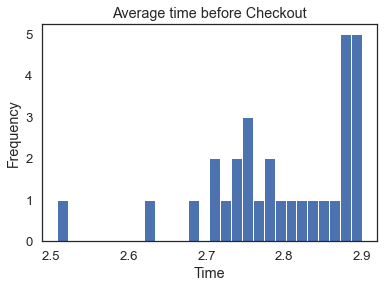

<Figure size 432x432 with 0 Axes>

In [4]:
#see the mean time it takes to get a free cashier
plt.hist(avg_ck,28)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Average time before Checkout')    
plt.figure(figsize=(6, 6))
plt.show()
#Plot appears to have a right skewed dsitribution

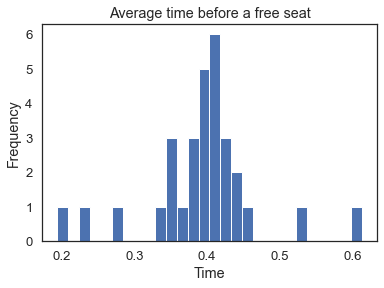

In [5]:
#see the mean time it takes to get a seat if they choose to stay
plt.hist(avg_seating,28)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Average time before a free seat')    
plt.show()
#normal distribution

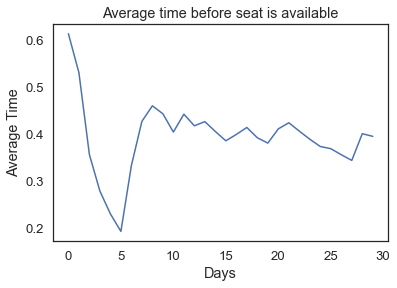

In [6]:
#mean seating queue time for 30 Days in the cafe
seat=avg_seating[0:30]
days=[]
for i in  range(30):
    days.append(i)

plt.plot(days,seat)
plt.xlabel('Days')
plt.ylabel('Average Time')
plt.title('Average time before seat is available')    
plt.show()
#bi-modal

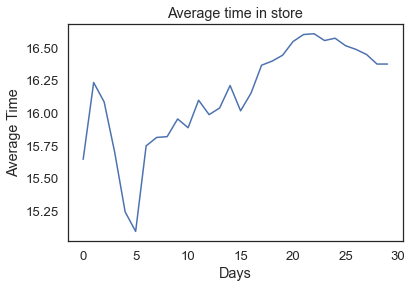

In [7]:
#Average time in store
m1=plt.plot(days,avg_inStore)
plt.xlabel('Days')
plt.ylabel('Average Time')
plt.title('Average time in store')    
plt.show()

### Model Optimization

We can see above from our charts above that the average time for a customer to be checkout was 3.6 minutes. From these results, if a customer chooses to stay in store then they are more likely to stay for 16.3 minutes in relation to the average. The store owner saw that the mean wait time for the seat declined after 15 days and wants to approve the average time between checkout and finding an open seat. He decides on two methods: increasing the number of seats to be ten and the other model have the another cashier and two new seating arrangements. Let's view the additional models performance

In [8]:
### Create a model to host ten seats with no change to # of cashiers
seat_queue[:]=[]
counter_queue[:]=[]
time_inStore[:]=[]
next_seat[:]=[]
avg_ck2=[]
avg_inStore2=[]
avg_seating2=[]
CHECK_OUT_TIME=5
CASHIERS=1
SEATING=10
SEAT_PROB=.25
CUSTOMER_ARR=5

for j in range (30):
    #run the enviornment for a month
    env=simpy.Environment()
    #set up simulation with one cashier, four available seats, 1/4 chance of a customer staying longer
    #run for the hours of operation 7am-6pm
    random.seed(60)
    env.process(run_sim(env,CASHIERS,SEATING,SEAT_PROB,CHECK_OUT_TIME,CUSTOMER_ARR))
    env.run(until=720)
    avg_ck2.append(mean(counter_queue))
    avg_seating2.append(mean(next_seat))
    avg_inStore2.append(mean(time_inStore))


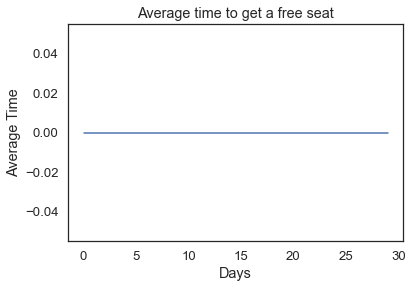

In [9]:
seat=avg_seating2[0:30]
m2=plt.plot(days,seat)
plt.xlabel('Days')
plt.ylabel('Average Time')
plt.title('Average time to get a free seat')    
plt.show()
#With ten seat, no one is waiting for a seat

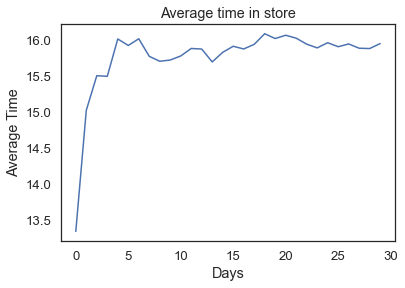

In [10]:
#Average time in store
m2=plt.plot(days,avg_inStore2)
plt.xlabel('Days')
plt.ylabel('Average Time')
plt.title('Average time in store')    
plt.show()
#Slight improvement in the average time in store

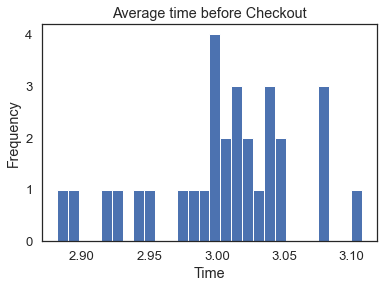

<Figure size 432x432 with 0 Axes>

In [11]:
#see the mean time it takes to get a free cashier
plt.hist(avg_ck2,28)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Average time before Checkout')    
plt.figure(figsize=(6, 6))
plt.show()

In [12]:
### Create a model to host six seats and a additional cashier
seat_queue[:]=[]
counter_queue[:]=[]
time_inStore[:]=[]
next_seat[:]=[]
avg_ck3=[]
avg_inStore3=[]
avg_seating3=[]
CHECK_OUT_TIME=5
CASHIERS=2
SEATING=6
SEAT_PROB=.25
CUSTOMER_ARR=5

for j in range (30):
    #run the enviornment for a month
    env=simpy.Environment()
    #set up simulation with one cashier, four available seats, 1/4 chance of a customer staying longer
    #run for the hours of operation 7am-6pm
    random.seed(60)
    env.process(run_sim(env,CASHIERS,SEATING,SEAT_PROB,CHECK_OUT_TIME,CUSTOMER_ARR))
    env.run(until=720)
    avg_ck3.append(mean(counter_queue))
    avg_seating3.append(mean(next_seat))
    avg_inStore3.append(mean(time_inStore))

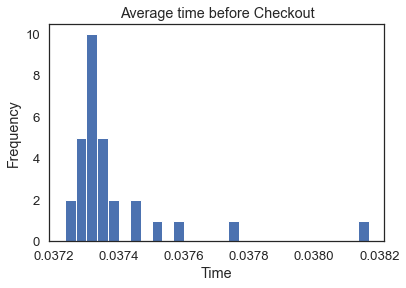

<Figure size 432x432 with 0 Axes>

In [13]:
#see the mean time it takes to get a free cashier
plt.hist(avg_ck3,28)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Average time before Checkout')    
plt.figure(figsize=(6, 6))
plt.show()

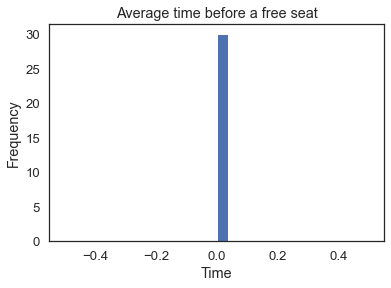

In [14]:
#see the mean time it takes to get a seat if they choose to stay
plt.hist(avg_seating3,28)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Average time before a free seat')    
plt.show()

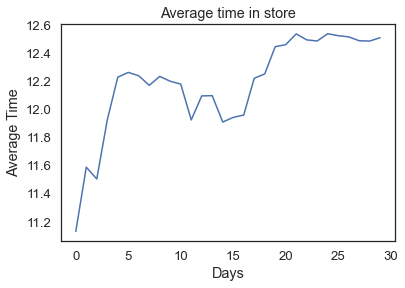

In [15]:
#Average time in store
m3=plt.plot(days,avg_inStore3)
plt.xlabel('Days')
plt.ylabel('Average Time')
plt.title('Average time in store')    
plt.show()

#### Final Thoughts



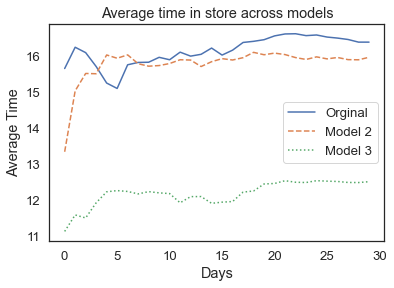

In [16]:
plt.plot(days,avg_inStore,label='Orginal')
plt.plot(days,avg_inStore2,linestyle='dashed',label='Model 2')
plt.plot(days,avg_inStore3,linestyle='dotted',label='Model 3')
plt.xlabel('Days')
plt.ylabel('Average Time')
plt.title('Average time in store across models') 
plt.legend()
plt.show()

The optimized models swa improvements from the original cafe flow. The model with the best improvements was the additional cashier and the two new seating arrangements, which sigificantly improved overall time in the cafe.